# BCG Corporate Project

**Company** : ClientCo

**Group Members**


Emilio Lopez, Eugenio Autrique, Guillermo Brun, Kangjie Yu, Mislav Ilijas



## Exploratory Data Analysis and Feature Engineering

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
pd.set_option('display.float_format', '{:.0f}'.format)

### Reading the parquet file

In [6]:
transactions_df = pd.read_parquet('transactions_dataset.parquet', engine='pyarrow')

In [7]:
transactions_df.shape

(63319315, 8)

In [8]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype  
---  ------         -----  
 0   date_order     object 
 1   date_invoice   object 
 2   product_id     int64  
 3   client_id      int64  
 4   sales_net      float64
 5   quantity       int64  
 6   order_channel  object 
 7   branch_id      int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 3.8+ GB


In [9]:
transactions_df.head()

,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id
0,2017-09-25,2017-09-25,2376333,188502,155,3,online,2732
1,2017-09-25,2017-09-25,2520527,835089,16,3,at the store,10279
2,2017-09-25,2017-09-25,2536756,1977896,366,21,online,6184
3,2017-09-25,2017-09-25,3028673,598816,9,201,at the store,4200
4,2017-09-25,2017-09-25,203377,2086861,1093,3,by phone,7051


### Changing data types of IDs and dates

In [10]:
transactions_df['product_id'] = transactions_df['product_id'].astype(str)
transactions_df['client_id'] = transactions_df['client_id'].astype(str)
transactions_df['branch_id'] = transactions_df['branch_id'].astype(str)

In [11]:
transactions_df['date_order'] = pd.to_datetime(transactions_df['date_order'])
transactions_df['date_invoice'] = pd.to_datetime(transactions_df['date_invoice'])

In [12]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63319315 entries, 0 to 63319314
Data columns (total 8 columns):
 #   Column         Dtype         
---  ------         -----         
 0   date_order     datetime64[ns]
 1   date_invoice   datetime64[ns]
 2   product_id     object        
 3   client_id      object        
 4   sales_net      float64       
 5   quantity       int64         
 6   order_channel  object        
 7   branch_id      object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 3.8+ GB


### Basic Descriptive Statistics

In [13]:
transactions_df.describe()

,date_order,date_invoice,sales_net,quantity
count,63319315,63319314,63319315,63319315
mean,2018-09-21 04:04:39.664808448,2018-09-26 05:22:19.385416448,148,92
min,2017-09-22 00:00:00,2016-10-12 00:00:00,-1738817,3
25%,2018-03-19 00:00:00,2018-03-22 00:00:00,14,3
50%,2018-09-21 00:00:00,2018-09-27 00:00:00,44,5
75%,2019-03-21 00:00:00,2019-03-26 00:00:00,131,21
max,2019-09-22 00:00:00,2021-07-13 00:00:00,1740456,198001
std,NaN,NaN,865,867


In [36]:
len(transactions_df.client_id.unique())

170589

### Problem Detection

In [38]:
# Definir una fecha de referencia (puede ser la fecha más reciente en el dataset)
reference_date = transactions_df['date_order'].max()

# Calcular la última fecha de compra para cada cliente
last_purchase = transactions_df.groupby('client_id')['date_order'].max().reset_index()
last_purchase.columns = ['client_id', 'last_purchase_date']

# Calcular los días desde la última compra hasta la fecha de referencia
last_purchase['days_since_last_purchase'] = (reference_date - last_purchase['last_purchase_date']).dt.days

# Definir el umbral de churn (ej. 180 días)
threshold_days = 180

# Etiquetar a los clientes como churn (True) o no churn (False)
last_purchase['churn'] = last_purchase['days_since_last_purchase'] > threshold_days

# Calcular la tasa de churn
churn_rate = last_purchase['churn'].mean() * 100
print(f"Churn Rate: {churn_rate:.2f}%")

Churn Rate: 29.76%


### Insights
* Based on the latest available date in the dataset 30% of the customer base of ClientCo has not made a purchase in the last 6 months
    * High churn rates can severely impact revenue and growth. 
    * This calls for an urgent need to investigate the underlying reasons for customer churn and implement effective retention strategies.

### Churn rate proportion by channel

In [18]:
# Merge churn information back to the original transactions dataframe
transactions_with_churn = transactions_df.merge(last_purchase[['client_id', 'churn']], on='client_id', how='left')

# Filtrar solo los clientes que han churned
churned_customers = transactions_with_churn[transactions_with_churn['churn'] == True]

# Agrupar por canal de ventas y contar el número de clientes únicos que han churned
churn_by_channel = churned_customers.groupby('order_channel')['client_id'].nunique().reset_index()
churn_by_channel.columns = ['order_channel', 'churned_customers_count']

# Calcular la proporción de churn por canal
total_churned_customers = churn_by_channel['churned_customers_count'].sum()
churn_by_channel['churn_proportion'] = (churn_by_channel['churned_customers_count'] / total_churned_customers) * 100

churn_by_channel

,order_channel,churned_customers_count,churn_proportion
0,at the store,38714,53
1,by phone,31557,43
2,during the visit of a sales rep,139,0
3,online,2028,3
4,other,1087,1


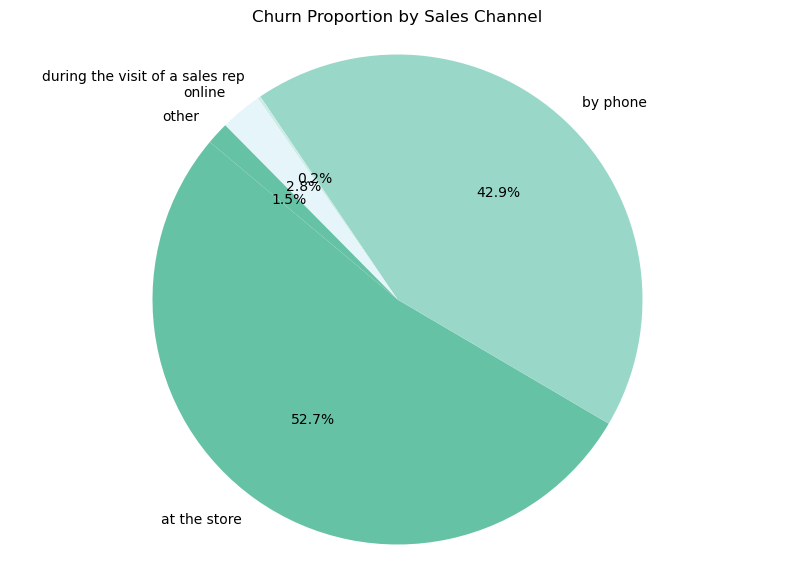

In [22]:
# Plotting the pie chart with better organization and labels
plt.figure(figsize=(10, 7))
colors = ['#66c2a5', '#99d8c9', '#ccece6', '#e5f5f9']
plt.pie(churn_by_channel['churn_proportion'], labels=churn_by_channel['order_channel'], autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Churn Proportion by Sales Channel')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the plot
plt.show()

### Estimating Financial Impact of the Churn Problem

In [23]:
# Valor promedio de compra
average_purchase_value = transactions_df['sales_net'].mean()

# Frecuencia de compra
purchase_frequency = transactions_df.groupby('client_id')['date_order'].count().mean()

# Duración del cliente (en años)
customer_lifespan = (transactions_df['date_order'].max() - transactions_df['date_order'].min()).days / 365

# Calcular el CLV promedio
average_clv = average_purchase_value * purchase_frequency * customer_lifespan
print(f"Average CLV: ${average_clv:.2f}")

# Paso 2: Calcular el Número de Clientes que han Churn
num_churned_customers = last_purchase[last_purchase['churn'] == True]['client_id'].nunique()
print(f"Number of Churned Customers: {num_churned_customers}")

# Paso 3: Cuantificar el Impacto Financiero
financial_impact = average_clv * num_churned_customers
print(f"Financial Impact of Churn: ${financial_impact:.2f}")

Average CLV: $109826.08
Number of Churned Customers: 50772
Financial Impact of Churn: $5576089552.22


### Plotting the Total Sales and Number of Transactions Over Time

Sales drops in:
* June 2018
* June 2019

/var/folders/_l/n0zr2f5507b_h55j03vp1tv40000gn/T/ipykernel_80297/1403291690.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = transactions_df.resample('M', on='date_order').agg({'sales_net': 'sum', 'client_id': 'count'}).rename(columns={'client_id': 'transaction_count'})


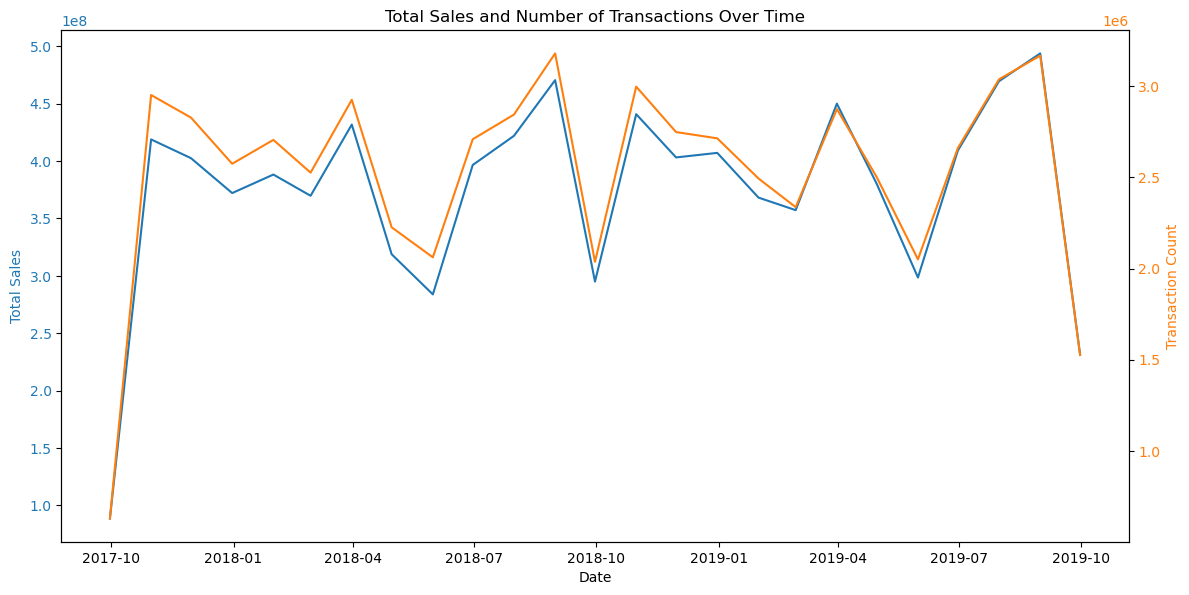

In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Resample data to monthly frequency and calculate total sales and transaction counts
monthly_sales = transactions_df.resample('M', on='date_order').agg({'sales_net': 'sum', 'client_id': 'count'}).rename(columns={'client_id': 'transaction_count'})

# Plot total sales over time
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Sales', color='tab:blue')
ax1.plot(monthly_sales.index, monthly_sales['sales_net'], color='tab:blue', label='Total Sales')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Transaction Count', color='tab:orange')
ax2.plot(monthly_sales.index, monthly_sales['transaction_count'], color='tab:orange', label='Transaction Count')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Total Sales and Number of Transactions Over Time')
plt.show()

### Analyzing the time lag between date_order and date_invoice

* We have a lot of negative values in the time lag (date invoice - date order)
* Why are there so many cases where the date invoice occurs before the order date? what is the reason behind?

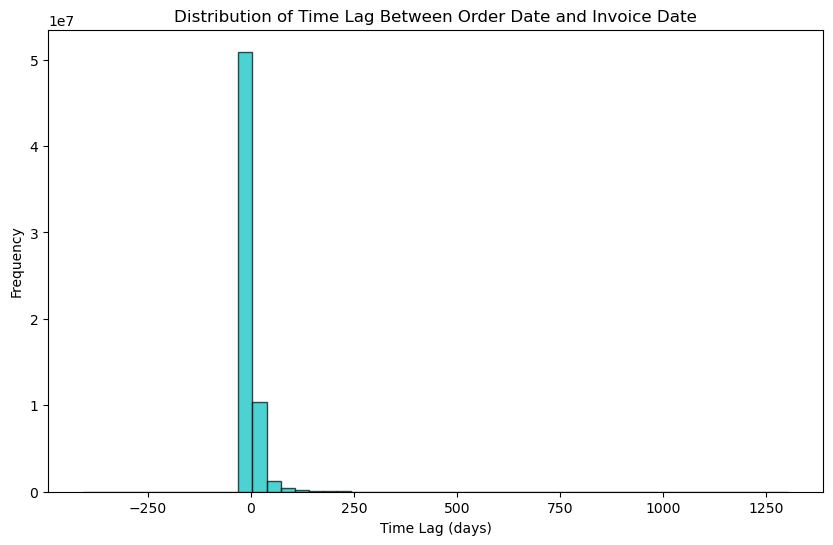

count   63319314
mean           5
std           20
min         -406
25%            0
50%            0
75%            1
max         1302
Name: time_lag, dtype: float64

In [26]:
# Calculate the time lag between order date and invoice date
transactions_df['time_lag'] = (transactions_df['date_invoice'] - transactions_df['date_order']).dt.days

# Plot the distribution of time lags
plt.figure(figsize=(10, 6))
plt.hist(transactions_df['time_lag'], bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Distribution of Time Lag Between Order Date and Invoice Date')
plt.xlabel('Time Lag (days)')
plt.ylabel('Frequency')
plt.show()

# Summary statistics of time lag
time_lag_summary = transactions_df['time_lag'].describe()
time_lag_summary

### Which Product Has Been Returned Most? (Assuming sales net < 0 = return)

In [27]:
# Identificar devoluciones por sales_net negativo
returns_df = transactions_df[transactions_df['sales_net'] < 0]

# Verificar si hay devoluciones
if not returns_df.empty:
    # Agrupar por product_id y sumar las cantidades absolutas de las devoluciones
    returned_quantities = returns_df.groupby('product_id')['quantity'].sum().abs().sort_values(ascending=False)
    top_5_returned_products = returned_quantities.head(5)
    
    print("Top 5 most returned products:")
    print(top_5_returned_products)
else:
    print("There are no returned products in the dataset.")

Top 5 most returned products:
product_id
539670     5228520
2681878    2189176
1492103    2072875
463156     1843447
932375     1823373
Name: quantity, dtype: int64


In [32]:
top_5_returned_products

product_id
539670     5228520
2681878    2189176
1492103    2072875
463156     1843447
932375     1823373
Name: quantity, dtype: int64

### Which Channels Are Most Effective in Driving Sales?

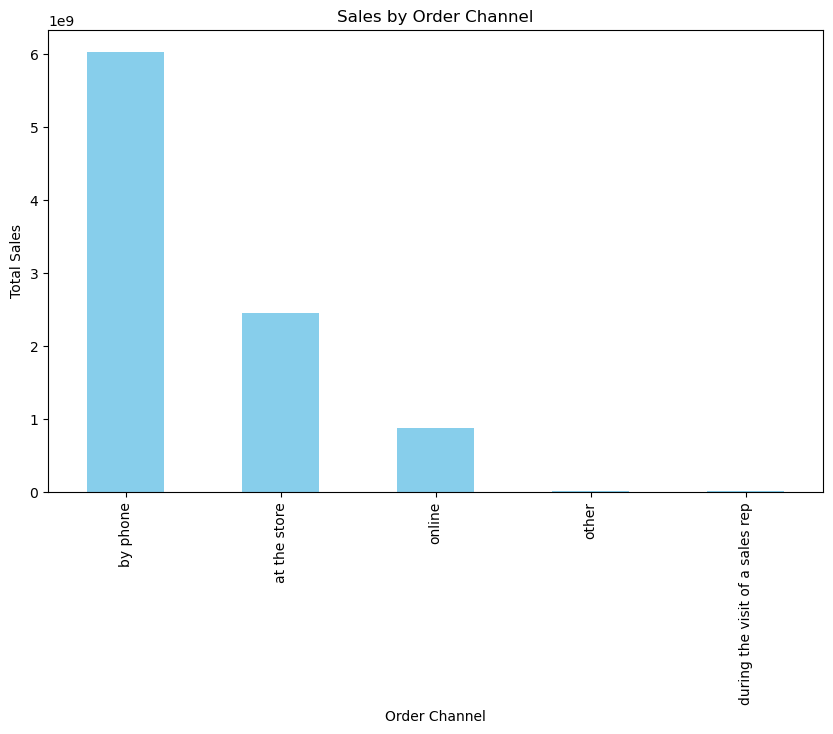

order_channel
by phone                          6030146776
at the store                      2450100515
online                             871020382
other                                8849452
during the visit of a sales rep      7443151
Name: sales_net, dtype: float64

In [28]:
# Group by order_channel and sum the sales_net
channel_sales = transactions_df.groupby('order_channel')['sales_net'].sum().sort_values(ascending=False)

# Plot the sales by channel
channel_sales.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Sales by Order Channel')
plt.xlabel('Order Channel')
plt.ylabel('Total Sales')
plt.show()

channel_sales

### Branches with the Highest and Lowest Sales and Transaction Counts
* Investigate branches with negative total sales 

Branch with highest sales: 3318 ($122620211.81118721)
Branch with lowest sales: 524 ($-2.842170943040401e-14)
Branch with highest transaction count: 3318 (643183 transactions)
Branch with lowest transaction count: 2925 (1 transactions)


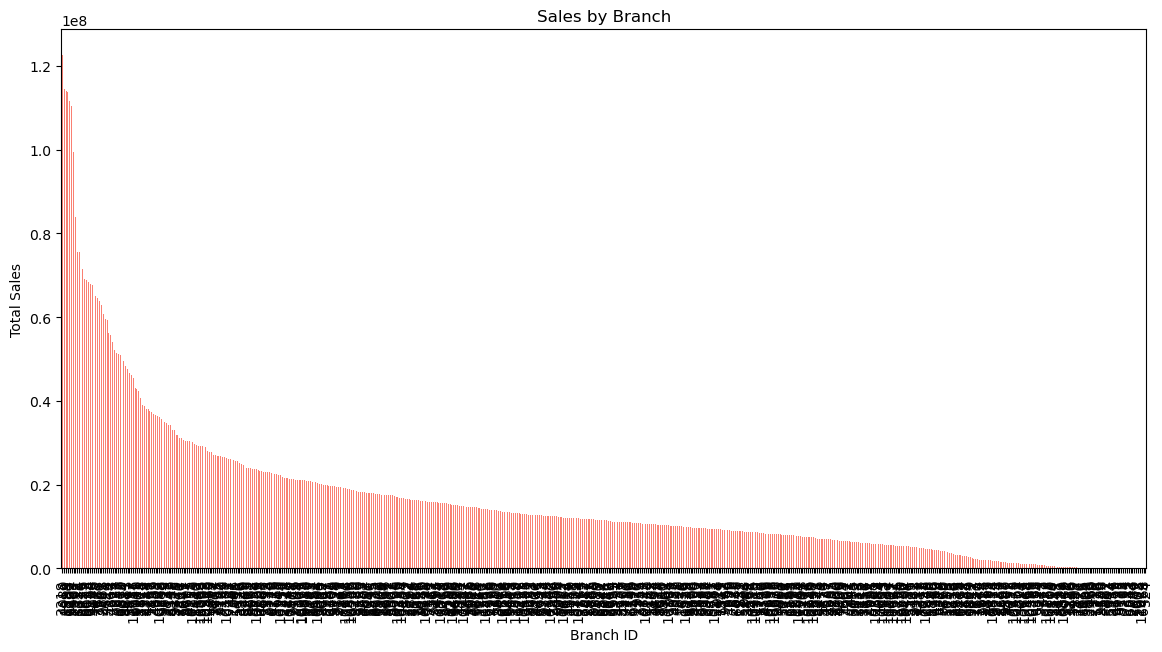

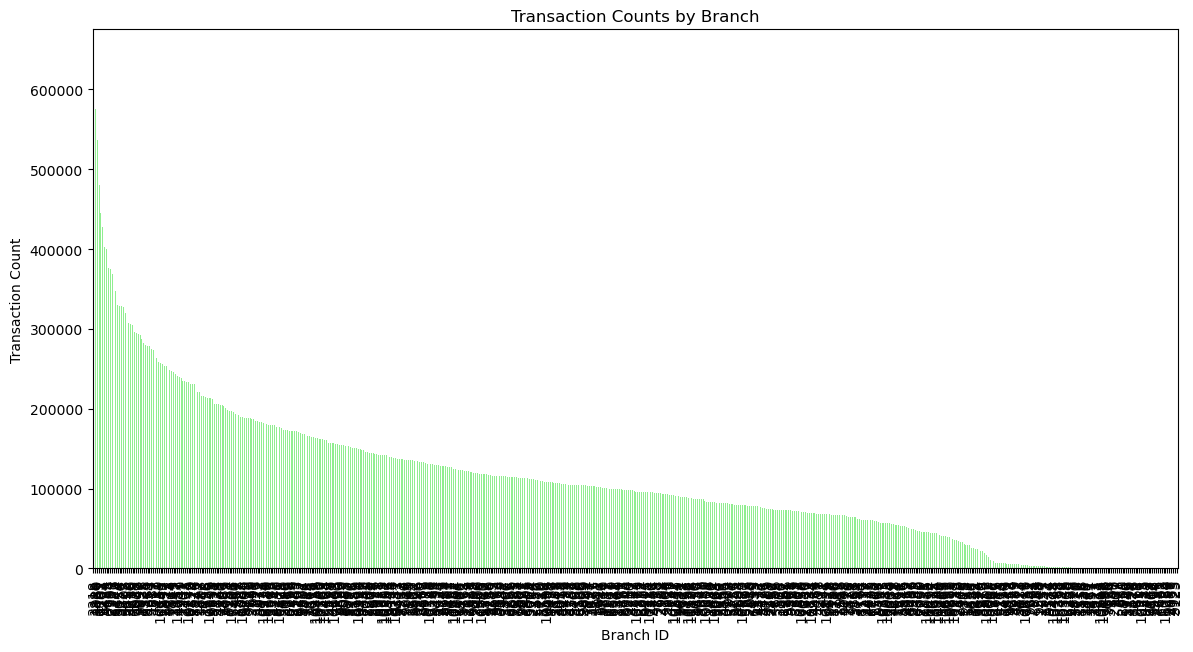

In [29]:
# Group by branch_id and sum the sales_net and count the transactions
branch_performance = transactions_df.groupby('branch_id').agg({'sales_net': 'sum', 'client_id': 'count'}).rename(columns={'client_id': 'transaction_count'})

# Identify highest and lowest branches
highest_sales_branch = branch_performance['sales_net'].idxmax()
lowest_sales_branch = branch_performance['sales_net'].idxmin()
highest_transaction_branch = branch_performance['transaction_count'].idxmax()
lowest_transaction_branch = branch_performance['transaction_count'].idxmin()

print(f"Branch with highest sales: {highest_sales_branch} (${branch_performance.loc[highest_sales_branch, 'sales_net']})")
print(f"Branch with lowest sales: {lowest_sales_branch} (${branch_performance.loc[lowest_sales_branch, 'sales_net']})")
print(f"Branch with highest transaction count: {highest_transaction_branch} ({branch_performance.loc[highest_transaction_branch, 'transaction_count']} transactions)")
print(f"Branch with lowest transaction count: {lowest_transaction_branch} ({branch_performance.loc[lowest_transaction_branch, 'transaction_count']} transactions)")

# Plot sales by branch
branch_performance['sales_net'].sort_values(ascending=False).plot(kind='bar', figsize=(14, 7), color='salmon')
plt.title('Sales by Branch')
plt.xlabel('Branch ID')
plt.ylabel('Total Sales')
plt.show()

# Plot transaction counts by branch
branch_performance['transaction_count'].sort_values(ascending=False).plot(kind='bar', figsize=(14, 7), color='lightgreen')
plt.title('Transaction Counts by Branch')
plt.xlabel('Branch ID')
plt.ylabel('Transaction Count')
plt.show()

### What’s the Customer Lifetime Value (CLV) of the Company?
* CLV = (Average Purchase Value) × (Purchase Frequency) × (Customer Lifespan)
* Next step: Calculate CLV at an individual level

In [30]:
# Calculate average purchase value, purchase frequency, and customer lifespan
average_purchase_value = transactions_df['sales_net'].mean()
purchase_frequency = transactions_df.groupby('client_id')['date_order'].count().mean()
customer_lifespan = (transactions_df['date_order'].max() - transactions_df['date_order'].min()).days / 365  # in years

# Calculate CLV
clv = average_purchase_value * purchase_frequency * customer_lifespan
print(f"The Customer Lifetime Value (CLV) of the company is approximately ${clv:.2f}")

The Customer Lifetime Value (CLV) of the company is approximately $109826.08


### Has Every Customer Made a Purchase?

In [31]:
# Check if every customer in the dataset has made at least one purchase
unique_customers = transactions_df['client_id'].nunique()
total_transactions = transactions_df['client_id'].count()

print(f"Total unique customers: {unique_customers}")
print(f"Total transactions: {total_transactions}")

# Assuming every row in the dataset represents a transaction, every customer has made a purchase.
print(f"Has every customer made a purchase? {'Yes' if unique_customers > 0 else 'No'}")

Total unique customers: 170589
Total transactions: 63319315
Has every customer made a purchase? Yes


# Feature engineering

## Creating the Client Dataset

In this section, we calculated for each of the customers the following features:

*RFM\
Average days between purchases\
Variance of purchase intervals\
Most common order channel\
Number of returns\
Most purchased product\
Number of unique products purchased\
Most common branch\
Total quantity purchased\
First purchase date\
Last purchase date\
Last invoice date\
CLV*

The dataset would be used for analysing the purchase behaviour of each client and support marketing stradegies.

### RFM

In [40]:
# Latest date in the dataset
latest_date = transactions_df['date_order'].max()

# Drop duplicate transactions per customer per day
unique_transactions = transactions_df.drop_duplicates(subset=['client_id', 'date_order'])

# Aggregate the data to calculate RFM metrics
rfm = transactions_df.groupby('client_id').agg({
    'date_order': lambda x: (latest_date - x.max()).days,
    'sales_net': 'sum'
}).reset_index()

# Calculate frequency from unique_transactions
frequency = unique_transactions.groupby('client_id')['date_order'].count()

# Merge frequency into the RFM dataframe
rfm = rfm.merge(frequency, on='client_id')

# Rename columns for clarity
rfm = rfm.rename(columns={
    'date_order': 'recency',
    'sales_net': 'monetary'
})

### Average Days Between Purchases

In [41]:
df = transactions_df.drop_duplicates(subset=['client_id', 'date_order'])
df = df.sort_values(by=['client_id', 'date_order'])
# calculate interval
df['purchase_interval'] = df.groupby('client_id')['date_order'].diff().dt.days
avg_days_between_purchases = df.groupby('client_id')['purchase_interval'].mean().reset_index(name='avg_days_between_purchases')

### Variance of Purchase Intervals

In [42]:
variance_df = df.groupby('client_id')['purchase_interval'].var().reset_index(name='purchase_interval_variance')
variance_df['purchase_interval_variance'] = variance_df['purchase_interval_variance'].fillna(0)
del df # Replace NaN with 0 for customers with only one purchase

### Most Common Order Channel

In [43]:
most_common_channel = transactions_df.groupby('client_id')['order_channel'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_order_channel')

### Number of Returns

In [45]:
returns = transactions_df[transactions_df['sales_net'] < 0].groupby('client_id').size().reset_index(name='returns')
returns['returns'] = returns['returns'].fillna(0)

### Most Purchased Product

In [46]:
most_purchased_product = transactions_df.groupby(['client_id', 'product_id']).size().reset_index(name='count')
most_purchased_product = most_purchased_product.loc[most_purchased_product.groupby('client_id')['count'].idxmax()].drop(columns='count')

### Number of Unique Products Purchased

In [47]:
unique_products = transactions_df.groupby('client_id')['product_id'].nunique().reset_index(name='unique_products')

### Most Common Branch

In [48]:
most_common_branch = transactions_df.groupby('client_id')['branch_id'].agg(lambda x: x.mode()[0]).reset_index(name='most_common_branch')

### Total Quantity Purchased

In [49]:
total_quantity = transactions_df.groupby('client_id')['quantity'].sum().reset_index(name='total_quantity')

### First Purchase Date

In [50]:
first_purchase_date = transactions_df.groupby('client_id')['date_order'].min().reset_index(name='first_purchase_date')

### Last Purchase Date

In [51]:
last_purchase_date = transactions_df.groupby('client_id')['date_order'].max().reset_index(name='last_purchase_date')

### Last Invoice Date

In [52]:
last_invoice_date = transactions_df.groupby('client_id')['date_invoice'].max().reset_index(name='last_invoice_date')

### CLV for each customer

In [53]:
#CLV value
avg_purchase_value = transactions_df.groupby('client_id')['sales_net'].mean()
# lifespan
customer_lifespan = (transactions_df.groupby('client_id')['date_order'].max() - transactions_df.groupby('client_id')['date_order'].min()).dt.days / 365
# calculation
clv = avg_purchase_value * frequency * customer_lifespan

clv_df = pd.DataFrame({'client_id': clv.index, 'CLV': clv.values})
print(clv_df.head())

  client_id  CLV
0    100000    3
1   1000001 9337
2   1000011    9
3   1000028   29
4   1000039  878


### Combining all the results

In [54]:
final_df = first_purchase_date \
    .merge(last_purchase_date, on='client_id') \
    .merge(last_invoice_date, on='client_id')\
    .merge(rfm, on='client_id') \
    .merge(avg_days_between_purchases, on='client_id') \
    .merge(most_common_channel, on='client_id') \
    .merge(returns, on='client_id', how='left') \
    .merge(most_purchased_product, on='client_id') \
    .merge(unique_products, on='client_id') \
    .merge(most_common_branch, on='client_id') \
    .merge(total_quantity, on='client_id') \
    .merge(variance_df, on='client_id')\
    .merge(customer_lifespan, on='client_id')\
    .merge(clv_df, on='client_id')

In [55]:
final_df=final_df.rename(columns={'date_order':'lifespan','date_order_x':'recency','date_order_y':'frequency'})

In [56]:
# Fill NA values in returns with 0
final_df['returns'] = final_df['returns'].fillna(0)
final_df['avg_days_between_purchases'] = final_df['avg_days_between_purchases'].fillna(0)

# Display the final DataFrame
final_df.head()

,client_id,first_purchase_date,last_purchase_date,last_invoice_date,recency,monetary,frequency,avg_days_between_purchases,most_common_order_channel,returns,product_id,unique_products,most_common_branch,total_quantity,purchase_interval_variance,lifespan,CLV
0,100000,2018-08-02,2018-08-06,2018-08-08,412,380,2,4,at the store,0,1043915,3,1574,11,0,0,3
1,1000001,2018-10-03,2019-09-13,2019-10-02,9,51396,64,5,online,1,980306,237,5012,130087,34,1,9337
2,1000011,2018-10-19,2018-10-30,2018-10-30,327,426,2,11,at the store,0,2159628,3,5710,19,0,0,9
3,1000028,2019-03-19,2019-08-02,2019-08-09,51,469,2,136,by phone,0,1216038,12,4717,280,0,0,29
4,1000039,2017-10-04,2018-12-27,2019-01-08,269,2205,11,45,at the store,0,382006,30,138,1098,3677,1,878


In [57]:
final_df.columns

Index(['client_id', 'first_purchase_date', 'last_purchase_date',
       'last_invoice_date', 'recency', 'monetary', 'frequency',
       'avg_days_between_purchases', 'most_common_order_channel', 'returns',
       'product_id', 'unique_products', 'most_common_branch', 'total_quantity',
       'purchase_interval_variance', 'lifespan', 'CLV'],
      dtype='object')

In [58]:
# Exporting the dataset
final_df.to_csv('client.csv')